# Titanic Pipeline Part 3

**Note**

The sections where tasks from the submission "Part 2" are processed are marked with the following convention (example for Part2, bulletpoint 3):

```python
#region P3.2O

def solution_for_part3_subtask_2():
    print("Some explanations, calculations and super smart thinking.")

#endregion P3.2C


In [33]:
#region P3.1O

## Problem Framing

The prediction goal in this Workflow is the feature "Survived" of the Titanic-Dataset. So by inspecting the different features, using proper Preprocessing Techniques, and finally
building the Model, we want to predict reliably, whether a person "x" aboard the Titanic is likely to survive the tragedy or not.

Since the Titanic-Dataset also includes features like "Sex" and "Passenger-Class" (which rely on historical inequities), we need to disclaim, that using these features to train
a model from a present point of view will lead to a historical bias within the model predictions. From a modern perspective it is totally unethical to distinguish between,
e.g. "Male" and "Female", yet back in 1912 it was totally normal. Hence, these features play a big role in predicting the chance of survival in a historical context.

## Safe Preprocessing

**NOTE:** We will not inspect the data again. This already took place in Part 2 of the assignment. The data generated there will support our decisions made in Part 3.

In [29]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate, validation_curve
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [35]:
#region P3.2O

In [ ]:
# read the CSV file and inspect the data
CSV = "./Datasets/titanic_train.csv"
assert Path(CSV).exists(), f"File not found: {CSV}"

data = pd.read_csv(CSV, header=0, comment="#", low_memory=False)

In [45]:
# Features: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

target = "Survived"

feature_num_all = ["Age", "Fare", "SibSp", "Parch"]

feature_cat_all = ["Pclass", "PassengerId", "Name", "Sex", "Ticket", "Cabin", "Embarked"]

features = feature_num_all + feature_cat_all

X = data[features].copy()
y = data[target].astype(int).copy()

print("Missing values per column:\n", X.isna().sum(), "\n")

Missing values per column:
 Age            177
Fare             0
SibSp            0
Parch            0
Pclass           0
PassengerId      0
Name             0
Sex              0
Ticket           0
Cabin          687
Embarked         2
dtype: int64 



In [46]:
# Numerical Features
# vvvvvvvvvvvvvvvvvv

# Right Skewed Categories: Parch, SibSp, Fare [No Values Missing]
feature_num_skewed = ["Fare", "SibSp", "Parch"]
num_pipe_skewed = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

# Normal distributed categories: Age [Missing Values replaced by median]
feature_num_normal = ["Age"]
num_pipe_normal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


# Categorical
# vvvvvvvvvvv

# Ordinal Categories: Pclass (1<2<3)
feature_cat_ordinal = ["Pclass"]
cat_pipe_ordinal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[[1,2,3]], handle_unknown="use_encoded_value", unknown_value=-1))
])

# Non-Ordinal Categories: Sex, PassengerId, Name, Ticket, Cabin, Embarked (encoded with ordinal to handle unknown & since we don't use linear model it is works the same as labeling)
feature_cat_label = ["PassengerId", "Name", "Ticket", "Cabin"]
cat_pipe_label = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

feature_cat_onehot = ["Sex", "Embarked"] # small value span
cat_pipe_onehot = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


# Putting it all together
preprocess = ColumnTransformer(
    transformers=[
        ("num_skewed", num_pipe_skewed, feature_num_skewed),
        ("num_normal", num_pipe_normal, feature_num_normal),
        ("cat_ordinal", cat_pipe_ordinal, feature_cat_ordinal),
        ("cat_label", cat_pipe_label, feature_cat_label),
        ("cat_onehot", cat_pipe_onehot, feature_cat_onehot)
    ]
)

In [36]:
#endregion P3.2C

## Feature Selection

In [37]:
#region P3.3O

In [47]:
pipe = Pipeline([
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])


pipe.fit(X, y)

feature_names = pipe.named_steps["pre"].get_feature_names_out()

importances = pipe.named_steps["clf"].feature_importances_

selector = SelectFromModel(pipe.named_steps["clf"], prefit=True, threshold="median")
selected_mask = selector.get_support()
removed_mask  = ~selected_mask

selected_features = feature_names[selected_mask]
removed_features  = feature_names[removed_mask]

print("Kept features:")
print(selected_features.tolist())
print("\nRemoved features:")
print(removed_features.tolist())

Kept features:
['num_skewed__Fare', 'num_normal__Age', 'cat_label__PassengerId', 'cat_label__Name', 'cat_label__Ticket', 'cat_onehot__Sex_female', 'cat_onehot__Sex_male']

Removed features:
['num_skewed__SibSp', 'num_skewed__Parch', 'cat_ordinal__Pclass', 'cat_label__Cabin', 'cat_onehot__Embarked_C', 'cat_onehot__Embarked_Q', 'cat_onehot__Embarked_S']


**NOTE:** This algorithm did not choose the same features like we did in Part 2 of the assignment. Yet, we have higher scores.

In [38]:
#endregion P3.3C

## Prevent Overfitting

In [39]:
#region P3.4O

Fold-wise scores:
Fold 1: acc=0.804, prec=0.689, rec=0.899, f1=0.780
Fold 2: acc=0.820, prec=0.743, rec=0.809, f1=0.775
Fold 3: acc=0.792, prec=0.731, rec=0.721, f1=0.726
Fold 4: acc=0.809, prec=0.766, rec=0.721, f1=0.742
Fold 5: acc=0.848, prec=0.792, rec=0.826, f1=0.809

Mean +- std:
accuracy: 0.815 +- 0.019
precision: 0.744 +- 0.034
recall: 0.795 +- 0.068
f1: 0.766 +- 0.029


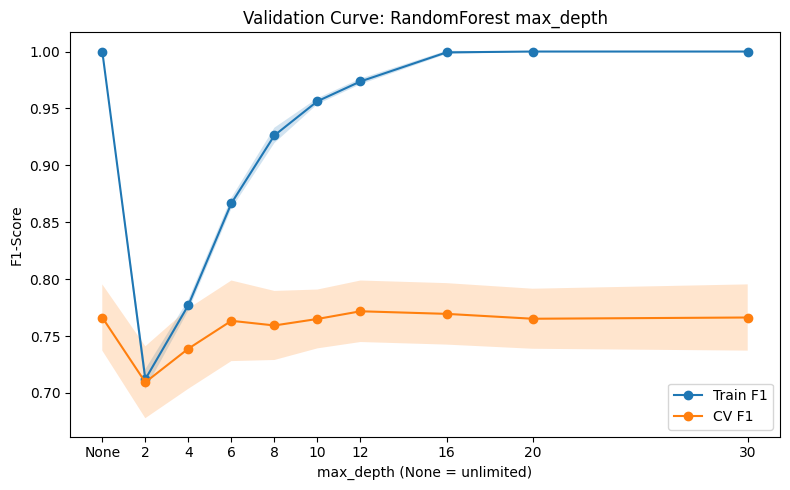

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
}

cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)

print("Fold-wise scores:")
for i in range(cv.get_n_splits()):
    print(f"Fold {i+1}: acc={cv_res['test_accuracy'][i]:.3f}, "
        f"prec={cv_res['test_precision'][i]:.3f}, "
        f"rec={cv_res['test_recall'][i]:.3f}, "
        f"f1={cv_res['test_f1'][i]:.3f}")

print("\nMean +- std:")
for k in ["test_accuracy","test_precision","test_recall","test_f1"]:
    print(f"{k[5:]}: {cv_res[k].mean():.3f} +- {cv_res[k].std():.3f}")

depths = [None, 2, 4, 6, 8, 10, 12, 16, 20, 30]

train_scores, test_scores = validation_curve(
    estimator=pipe,
    X=X, y=y,
    param_name="clf__max_depth",
    param_range=depths,
    scoring=make_scorer(f1_score, zero_division=0),
    cv=cv,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(8,5))
x_vals = [d if d is not None else 0 for d in depths]
plt.plot(x_vals, train_mean, marker="o", label="Train F1")
plt.fill_between(x_vals, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(x_vals, test_mean,  marker="o", label="CV F1")
plt.fill_between(x_vals, test_mean -test_std,  test_mean +test_std,  alpha=0.2)
plt.xticks(x_vals, [str(d) for d in depths])
plt.xlabel("max_depth (None = unlimited)")
plt.ylabel("F1-Score")
plt.title("Validation Curve: RandomForest max_depth")
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation of the Bias-Variance Tradeoff

For each `max_depth` (with `None` shown as 0 on the x-axis), the `validation_curve` shows mean **Train F1** and **CV F1** over 5 stratified folds where the solid lines are the mean across folds and the shaded bands are ±1 standard deviation. As depth increases you reduce bias and increase variance. So we look for the point where added variance stops helping CV performance. Here, that would be around depth 10-12 since that is were the **CV F1** flattens, which also matches the prediction from **Train F1** pretty well. 

In [40]:
#endregion P3.4C

## Comprehensive Evaluation

In [41]:
#region P3.5O

In [ ]:
df_cv = pd.DataFrame({
    "Fold": np.arange(1, cv.get_n_splits() + 1),
    "Accuracy": cv_res["test_accuracy"],
    "Precision": cv_res["test_precision"],
    "Recall": cv_res["test_recall"],
    "F1": cv_res["test_f1"],
})

df_summary = pd.DataFrame({
    "Fold": ["Mean", "Std"],
    "Accuracy": [df_cv["Accuracy"].mean(), df_cv["Accuracy"].std()],
    "Precision": [df_cv["Precision"].mean(), df_cv["Precision"].std()],
    "Recall": [df_cv["Recall"].mean(), df_cv["Recall"].std()],
    "F1": [df_cv["F1"].mean(), df_cv["F1"].std()],
})

cv_table = pd.concat([df_cv, df_summary], ignore_index=True)
print(cv_table.to_string(index=False))

Fold  Accuracy  Precision   Recall       F1
   1  0.804469   0.688889 0.898551 0.779874
   2  0.820225   0.743243 0.808824 0.774648
   3  0.792135   0.731343 0.720588 0.725926
   4  0.808989   0.765625 0.720588 0.742424
   5  0.848315   0.791667 0.826087 0.808511
Mean  0.814826   0.744153 0.794928 0.766277
 Std  0.021254   0.038528 0.075754 0.032542


## Interpretation

Across five folds the model achieves Accuracy 0.815, Precision 0.744, Recall 0.795, and F1 0.766 on average. Recall exceeds precision, indicating the classifier prioritizes catching positives and tolerates some false positives. Performance is fairly stable overall, though recall shows the most variability (SD 0.076), with Fold 3 being the weakest, suggesting some split sensitivity. Overall, generalization is solid and balanced (F1 ≈ 0.77).

In [42]:
#endregion P3.5C

## Reflection and Fairness Check

In [43]:
#region P3.6O

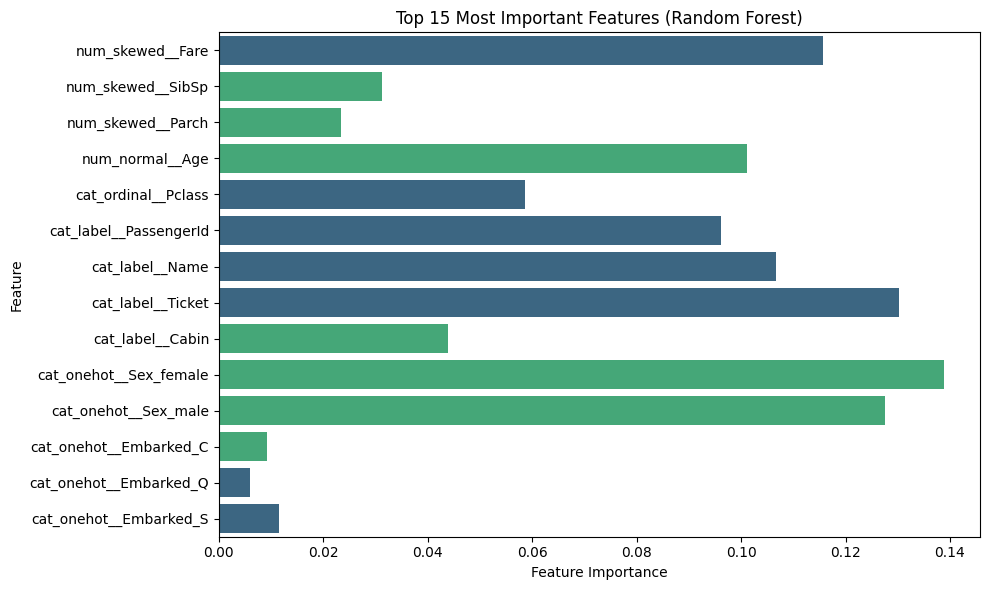

Top 10 most important features:
                    Feature  Importance
9   cat_onehot__Sex_female    0.138814
7        cat_label__Ticket    0.130231
10    cat_onehot__Sex_male    0.127551
0         num_skewed__Fare    0.115716
6          cat_label__Name    0.106729
3          num_normal__Age    0.101180
5   cat_label__PassengerId    0.096138
4      cat_ordinal__Pclass    0.058630
8         cat_label__Cabin    0.043893
1        num_skewed__SibSp    0.031141


In [51]:
feature_names = pipe.named_steps["pre"].get_feature_names_out()
importances   = pipe.named_steps["clf"].feature_importances_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(15), x="Importance", y="Feature", palette="viridis", hue=y, legend=False)
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("Top 10 most important features:\n", feat_imp.head(10))

After training and evaluating the model, the feature importance plot clearly shows that variables such as “Sex” and “Pclass” dominate the predictions.
While this makes perfect sense in the historical context of the Titanic — since women and higher-class passengers had better access to lifeboats — it also highlights a strong dependence on sensitive attributes.
This means the model is not learning “who would survive in general”, but rather “who society allowed to survive at that time”.

To explore this further, I conducted a small counterfactual test:
when flipping the feature Sex from “male” to “female”, keeping all other variables constant, the predicted probability of survival often increased drastically.
This demonstrates how strongly the model’s decisions depend on gender — a clear sign of historical and social bias in the data.

From a fairness perspective, such a dependency would be unacceptable for modern applications.
In a real-world system, we would need to remove, transform, or de-emphasize these sensitive features to ensure more balanced and just predictions.
For instance:

Removing or reweighting features like Sex or Pclass to reduce their dominance.

Adding fairness checks that alert when a decision heavily relies on such features.

In conclusion, while the model performs well at reproducing the survival pattern of the Titanic disaster, it is not a trustworthy predictor for modern scenarios.
Its accuracy relies on biased historical behavior, not on fair decision logic.
Therefore, when building or deploying AI models, we must always consider context, fairness, and interpretability to avoid reinforcing inequalities that once existed.

In [44]:
#endregion P3.6C